<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Playground/Testset_2021_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=0941cf2014a71bc9283c0ed4bc1f9612cde05d70dd2715d19fbc3388fe7ebc9e
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Loading and cleaning data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  LDA_NRC.html    LDA_Trouw.png	  Volkskrant_2021.json
LDA_all.html	     LDA_NRC.png     NRC_2021.json
LDA_all.png	     LDA__.png	     Telegraaf_2021.json
LDA__.html	     LDA_Trouw.html  Trouw_2021.json


In [4]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

In [5]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

In [6]:
df_NRC["Source"] = "NRC"
df_Trouw["Source"] = "Trouw"
df_HetParool["Source"] = "HetParool"
df_Telegraaf["Source"] = "Telegraaf"
df_Volkskrant["Source"] = "Volkskrant"

In [17]:
print(df_NRC.shape)
print(df_Trouw.shape)
print(df_HetParool.shape)
print(df_Volkskrant.shape)

(38334, 7)
(21077, 7)
(18551, 7)
(143876, 7)
(25773, 7)


## Concat data

In [7]:
dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Source
0,https://www.nrc.nl/nieuws/2021/01/31/een-herha...,2021-01-31 20:18:43,Een herhaling van vorig seizoen is zo goed als...,Fabian van der Poll,De eerste maand van 2021 is uitstekend verlope...,None,NRC
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC
2,https://www.nrc.nl/nieuws/2021/01/31/school-op...,2021-01-31 19:58:21,"School open? Dan testen, ventilatie en mondkapjes",Karel Berkhout,Door de heropening van de scholen loopt het aa...,None,NRC
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC
4,https://www.nrc.nl/nieuws/2021/01/31/arrestati...,2021-01-31 19:43:49,Arrestatie Russische betoger,None,,None,NRC


## Remove missing text

In [14]:
df = df[df['cleantext'].notna()]
print(df.shape)

(103723, 7)


# Coverage Bias

In [ ]:
def visualise_term_mention(frame, words, normalisation=True):
  df = frame.copy(deep=True)

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("Source")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("Source")

  df_word_mentions = df_word_mentions.rename(columns={'variable':'Word','value':'Frequency'})
    
  if normalisation:
    df_norm = df_word_mentions.groupby('Source').sum('Frequency').reset_index().rename(columns={'Frequency':'Total Freq'})
    df_word_mentions = df_word_mentions.merge(df_norm, on='Source')
    df_word_mentions['Normalised_Freq'] = np.log(df_word_mentions['Frequency']/df_word_mentions['Total Freq'])
     
  mentions = df_word_mentions.pivot("Word", "Source", "Normalised_Freq")
  mentions = mentions.reindex(words.keys())

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(15,9))
  # Time series plot with Seaborn lineplot()
  sns.heatmap(mentions, cmap="YlGnBu")
  # axis labels
  plt.title("Newspaper Normalised Frequency")

In [ ]:
zetelverdeling = {'Party': ['VVD','CDA','D66','PvdA',
                            'PVV','GL','SP','SGP','BBB',
                            'Volt','CU','FVD','BIJ1',
                            '50PLUS','PvdD','JA21',],
                   'Zetel': [34, 15, 24, 9, 17, 8,
                              9, 3, 1, 3, 5, 8, 1, 
                              1, 6, 3,]}
df_zetels = pd.DataFrame(data=zetelverdeling).sort_values('Zetel', ascending=False)

df_zetels.head()

,Party,Zetel
0,VVD,34
2,D66,24
4,PVV,17
1,CDA,15
3,PvdA,9


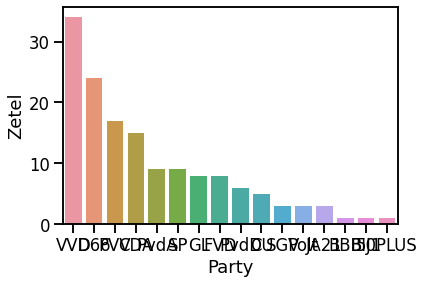

In [ ]:
sns.barplot(data=df_zetels, x='Party', y='Zetel')

In [18]:
partijen_termen = {'VVD':['VVD', 'Volkspartij voor Vrijheid en Democratie',],
                   'D66':['D66', 'Democraten 66', "D'66"],
                   'PVV':['PVV', 'Partij voor de Vrijheid'],
                   'CDA':['CDA', 'Christen-Democratisch Appèl'],
                   'PvdA':['PvdA','PVDA', 'Partij van de Arbeid'],
                   'SP':['SP', 'Socialistische Partij'],
                   'GL':['GL', 'GroenLinks'],
                   'FVD': ['FVD', 'Forum Voor Democratie'],
                   'PvdD':['PvdD','Partij voor de Dieren'],
                   'CU':['CU', 'Christen Unie'],
                   'SGP':['SGP', 'Staatkundig Gereformeerde Partij'],
                   'Volt':['Volt'],
                   'JA21':['JA21'],
                   'BBB':['BBB', 'Boeren Burger Beweging'],
                   'BIJ1':['BIJ1'],
                   '50PLUS':['50PLUS'],
                   }

print(partijen_termen.keys())                

dict_keys(['VVD', 'D66', 'PVV', 'CDA', 'PvdA', 'SP', 'GL', 'FVD', 'PvdD', 'CU', 'SGP', 'Volt', 'JA21', 'BBB', 'BIJ1', '50PLUS'])


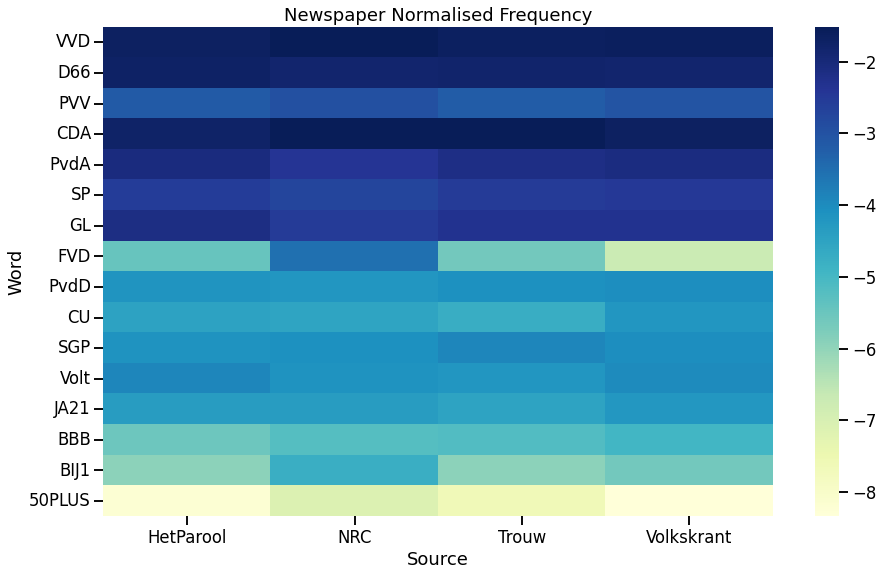

In [ ]:
# Rutte 3: VVD, D66, CDA, CU
visualise_term_mention(df, partijen_termen)

In [19]:
politici_termen = {'Rutte':['Rutte'],
                   'Kaag':['Kaag'],
                   'Wilders':['Wilders'],
                   'Hoekstra':['Hoekstra'],
                   'Ploumen':['Ploumen'],
                   'Marijnissen':['Marijnissen'],
                   'Klaver':['Klaver'],
                   'Baudet': ['Baudet'],
                   'Ouwehand':['Ouwehand'],
                   'Segers':['Segers'],
                   'Staaij':['Staaij'],
                   'Dassen':['Dassen'],
                   'Eerdmans':['Eerdmans'],
                   'Plas':['Plas'],
                   'Simons':['Simons'],
                   'Den Haan':['Den Haan'],
                   }

print(politici_termen.keys())

dict_keys(['Rutte', 'Kaag', 'Wilders', 'Hoekstra', 'Ploumen', 'Marijnissen', 'Klaver', 'Baudet', 'Ouwehand', 'Segers', 'Staaij', 'Dassen', 'Eerdmans', 'Plas', 'Simons', 'Den Haan'])


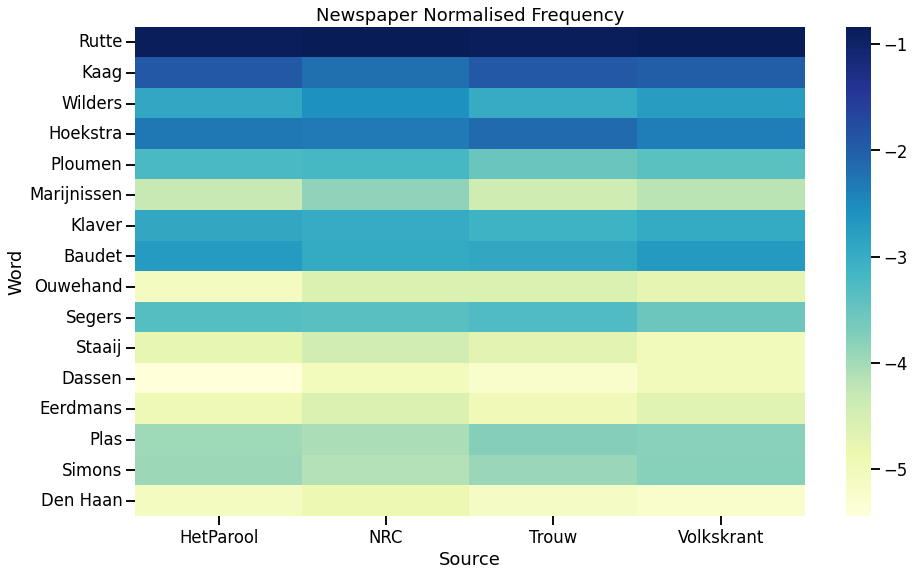

In [ ]:
visualise_term_mention(df, politici_termen)

In [ ]:
def visualise_relative_mention(frame, words, normalisation=True):
  df = frame.copy(deep=True)

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("Source")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("Source")

  df_word_mentions = df_word_mentions.rename(columns={'variable':'Word','value':'Frequency'})

  df_ave = pd.DataFrame(df_word_mentions.groupby('Word').mean()).reset_index().rename(columns={'Frequency':'Average'})
  df_word_mentions = df_word_mentions.merge(df_ave, on='Word')
  df_word_mentions['Frequency'] = df_word_mentions['Frequency']/df_word_mentions['Average']
    
  if normalisation:
    df_norm = df_word_mentions.groupby('Source').sum('Frequency').reset_index().rename(columns={'Frequency':'Total Freq'})
    df_word_mentions = df_word_mentions.merge(df_norm, on='Source')
    df_word_mentions['Normalised_Freq'] = df_word_mentions['Frequency']/df_word_mentions['Total Freq']
    
  mentions = df_word_mentions.pivot("Word", "Source", "Normalised_Freq")
  mentions = mentions.reindex(words.keys())

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(15,9))
  # Time series plot with Seaborn lineplot()
  sns.heatmap(mentions, cmap='coolwarm')
  # axis labels
  plt.title("Newspaper Relative Normalised Frequency")

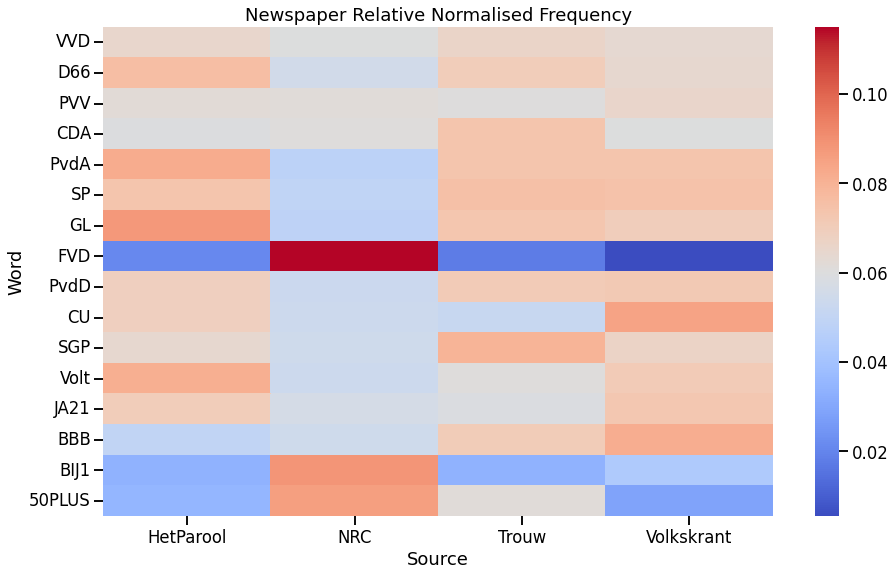

In [ ]:
visualise_relative_mention(df, partijen_termen)

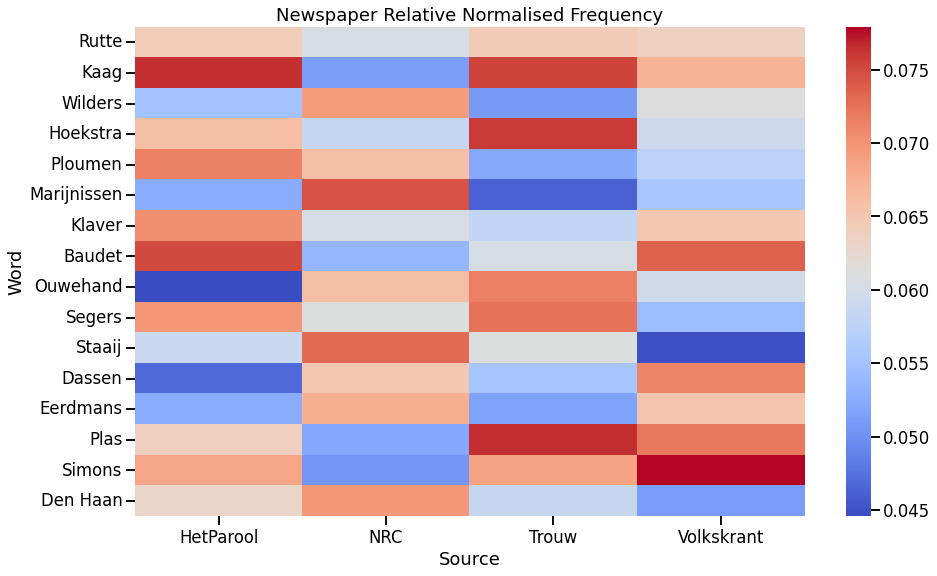

In [ ]:
visualise_relative_mention(df, politici_termen)

# LDA

In [81]:
def lda_analysis(frame, path_lda, path_plot, topics=10):
  # Remove the columns
  articles = frame.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers

  articles = articles[articles['cleantext'].notna()]

  # Remove punctuation
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
  # Save D66
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
  # Save BIJ1
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
  # Save 50PLUS
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
  # Save JA21
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
  # Convert the titles to lowercase
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

  # party_and_pol = 'pvv|groenlinks|pvda|sp|dzeszes|vvd|sgp|bbb|volt|cu|cda|fvd|bijeeen|vijfplus|pvdd|jatweeeen|rutte|kaag|wilders|hoekstra|ploumen|marijnissen|klaver|baudet|ouwehand|segers|staaij|dassen|eerdmans|plas|simons|den haan|'

  p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
             'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
             'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
             'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
             'simons', 'den haan']

  
  pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
  articles = articles[articles['cleantext_processed'].str.contains(pat)]
  #articles = articles[articles['cleantext_processed'].str.contains(p_and_p).any(axis=1)]
  # articles = articles[articles['cleantext_processed'].str.contains(party_and_pol, regex=True)]
  print(articles.shape)

  stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

  def sent_to_words(sentences):
      for sentence in sentences:
          # deacc=True removes punctuations
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) 
              if word not in stop_words] for doc in texts]

  data = articles.cleantext_processed.values.tolist()
  data_words = list(sent_to_words(data))# remove stop words
  data_words = remove_stopwords(data_words)

  #print(data_words[:1][0][:30])

  # Create Dictionary
  id2word = corpora.Dictionary(data_words)

  # Create Corpus
  texts = data_words

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # View
  #print(corpus[:1][0][:30])

  # number of topics
  num_topics = topics
  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
  doc_lda = lda_model[corpus]

  def terms_topics_frame(terms):

    df = pd.DataFrame(data=None)

    for t in terms:
      df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
      df_t_topics = df_t_topics.drop(columns=0)
      df_t_topics = df_t_topics.rename(columns={1:t})
      df = pd.concat([df, df_t_topics], axis=1)
    
    return df

  df_tt = terms_topics_frame(['vvd','dzeszes','pvv','cda', 'pvda',  'sp','groenlinks','fvd','pvdd','cu',
                                'sgp','volt','jatweeeen','bbb', 'bijeeen', 'vijfplus']
  )
  df_tt['topic'] = df_tt.index

  sns.set_theme(style="whitegrid")

  # Plot the topic dist per term
  fig = df_tt.set_index('topic').plot(kind='bar', figsize=(20,20), stacked=True)
  fig.figure.savefig(path_plot)

  # Visualize the topics
  pyLDAvis.enable_notebook()
  LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
  LDAvis = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
  pyLDAvis.save_html(LDAvis, path_lda) 


(15498, 5)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


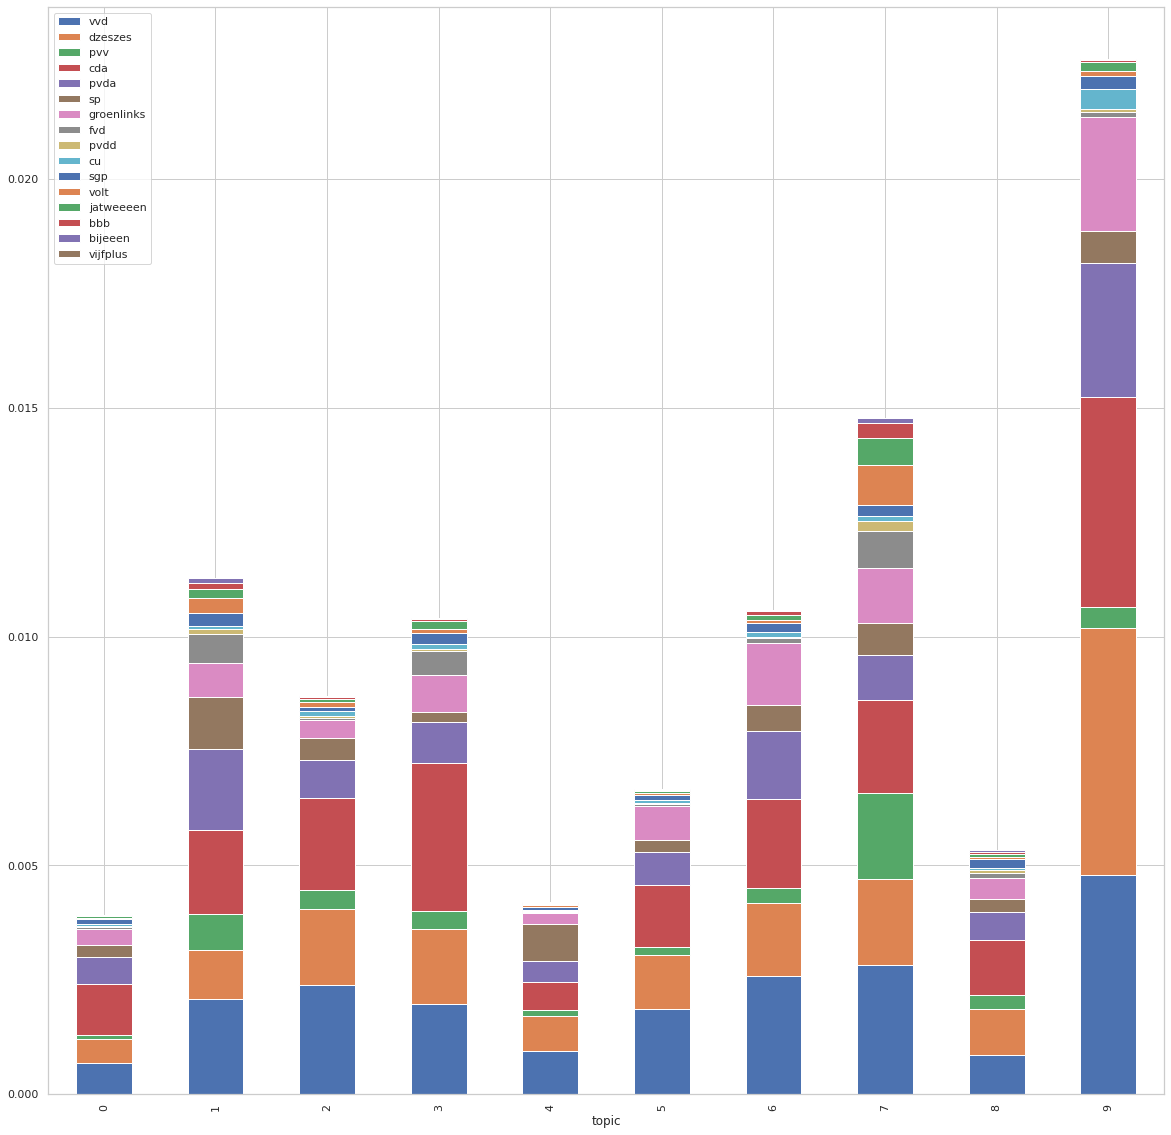

In [88]:
lda_analysis(df,'gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_All.html','gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_All.png',topics=10)

(6423, 5)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


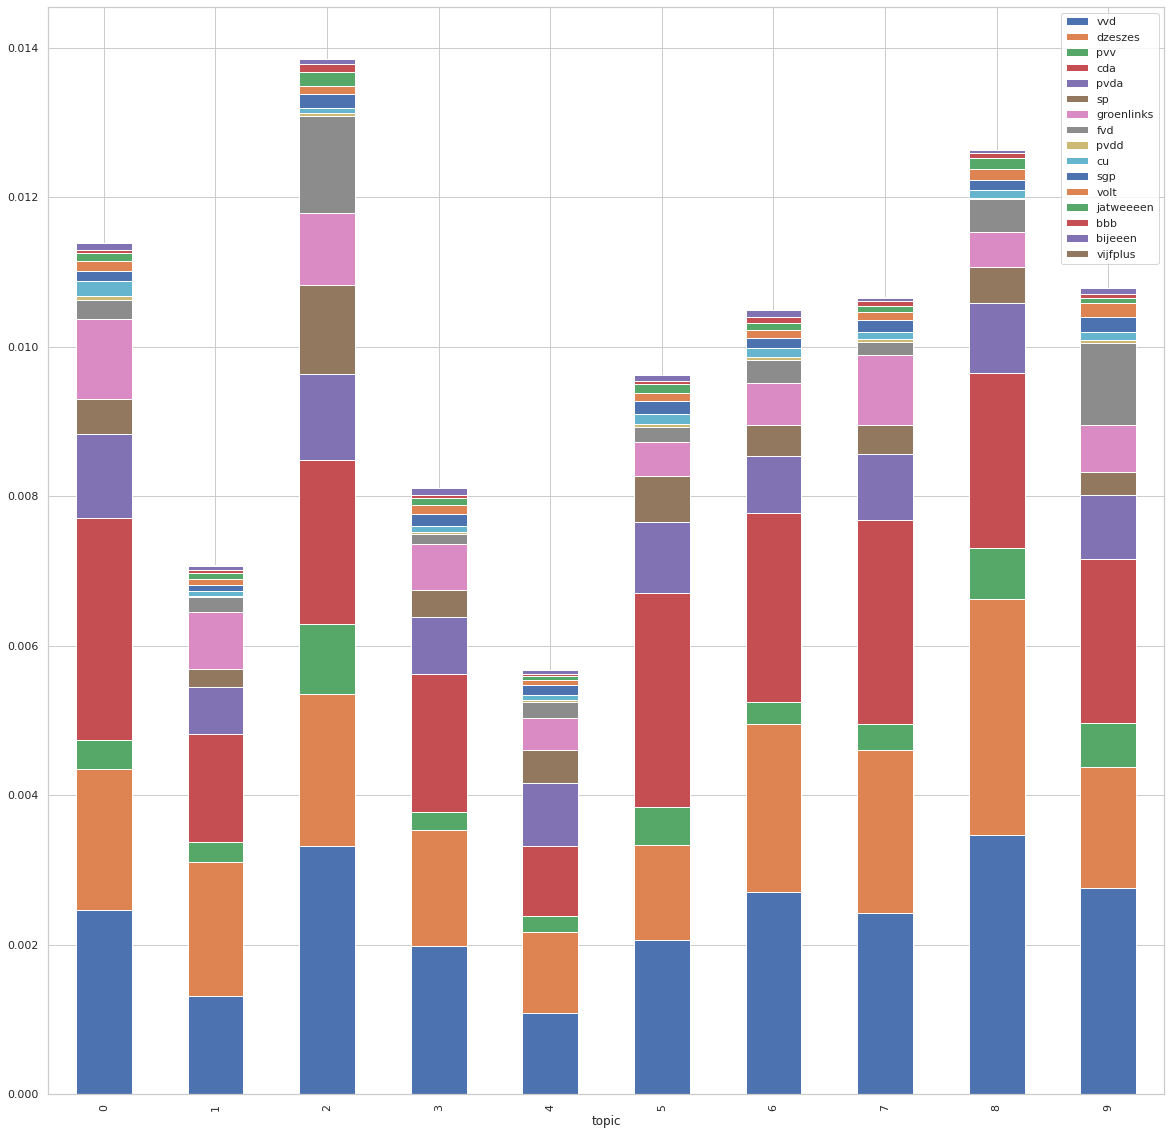

In [89]:
lda_analysis(df_NRC,'gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_NRC.html','gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_NRC.png',topics=10)

(2874, 5)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


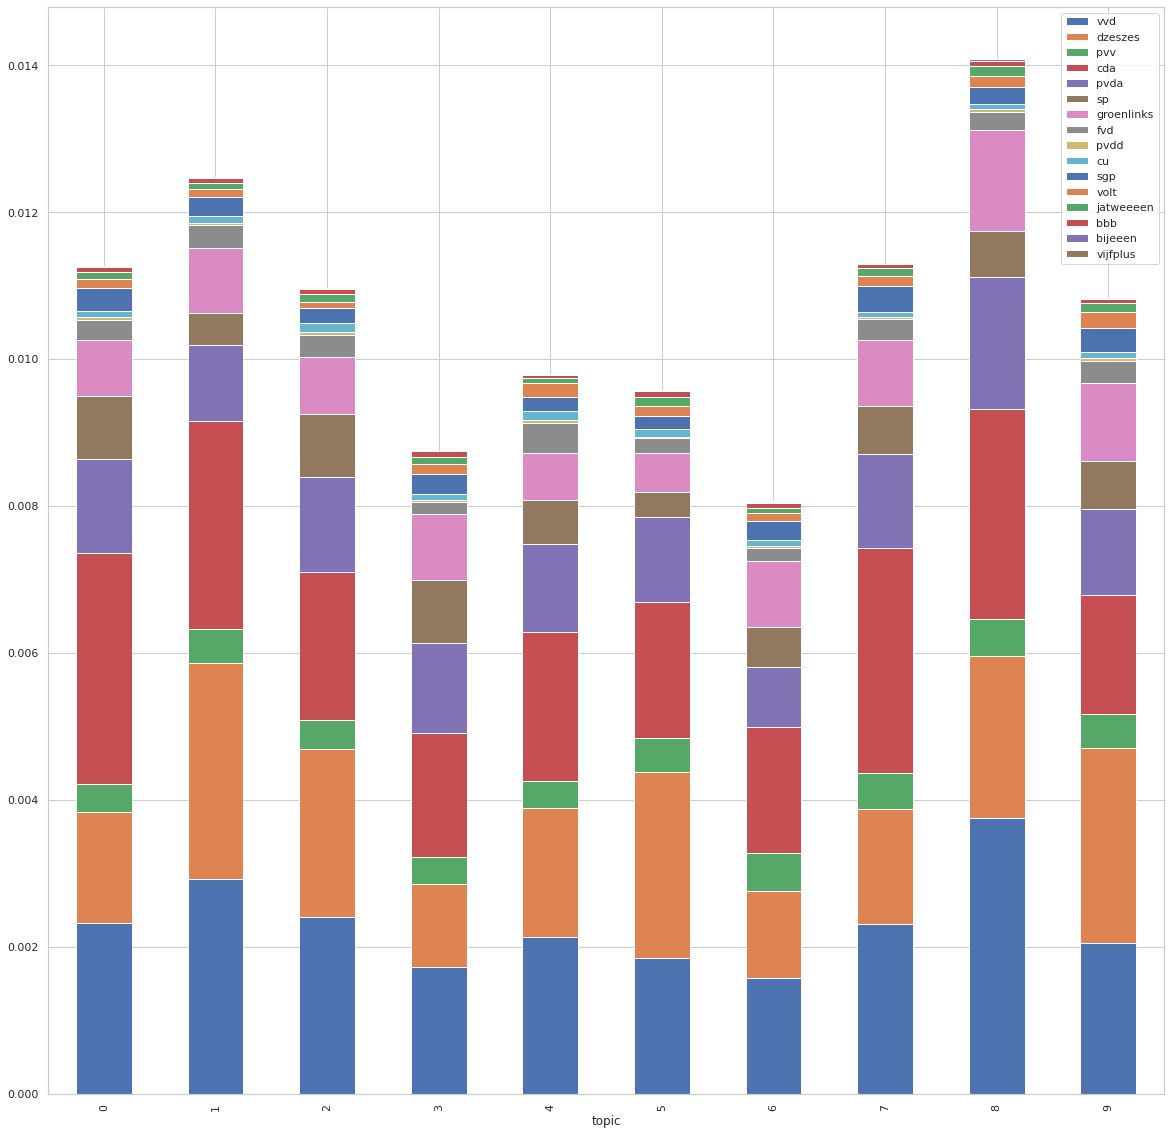

In [90]:
lda_analysis(df_Trouw,'gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_Trouw.html','gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_Trouw.png',topics=10)

(2452, 5)


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


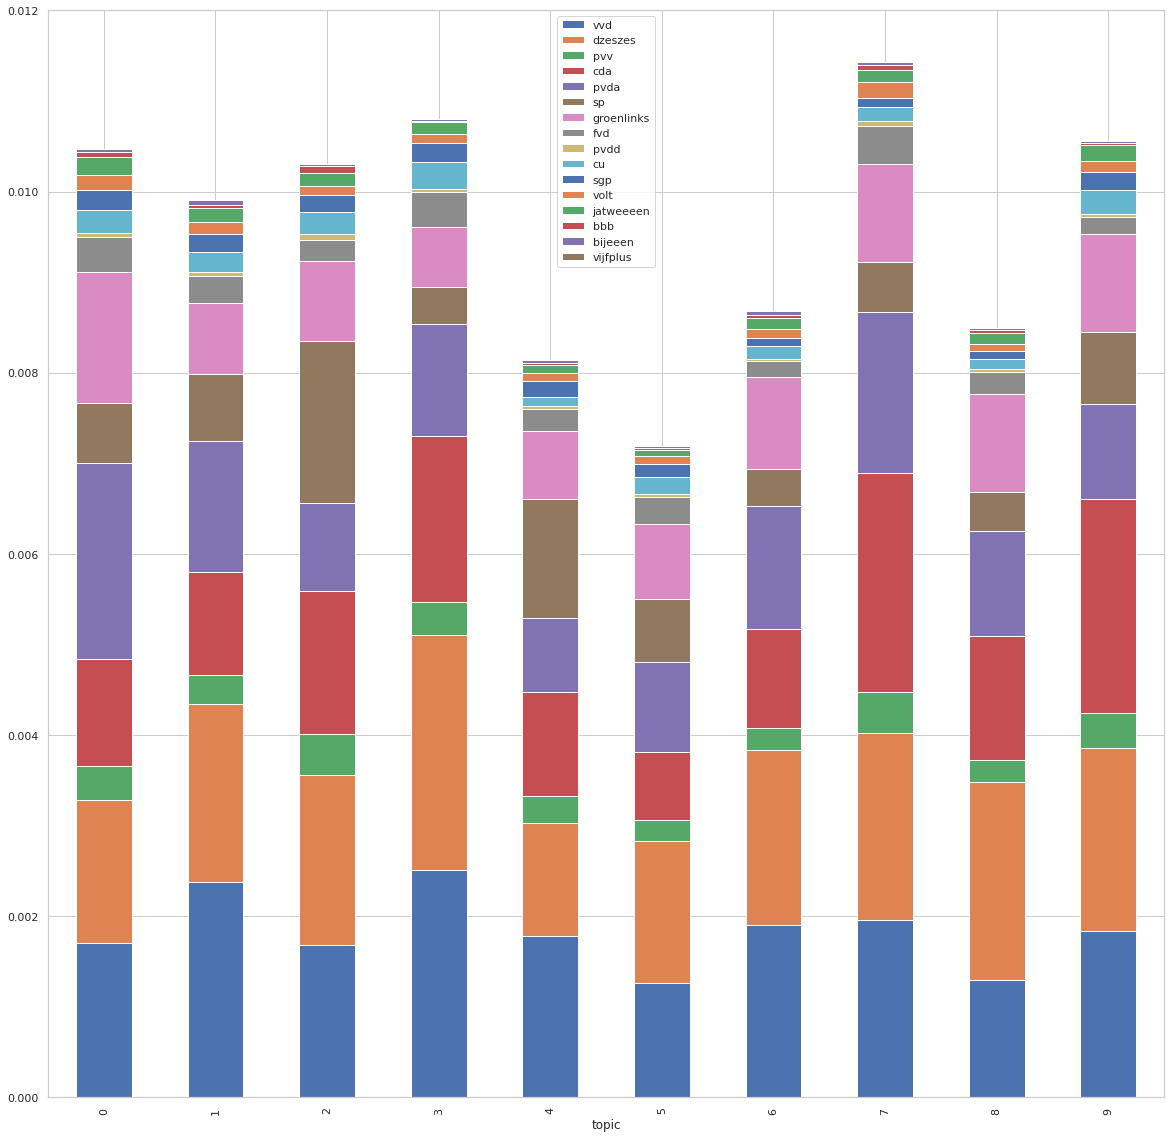

In [91]:
lda_analysis(df_HetParool,'gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_HetParool.html','gdrive/MyDrive/CS/Thesis/Testset_2021/LDA_HetParool.png',topics=10)

# Word2vec

In [94]:
p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
            'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
            'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
            'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
            'simons', 'den haan']

pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
df_political = df[df['cleantext'].str.contains(pat)]

In [95]:
from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models
from tqdm import tqdm

In [97]:
corpus = list(df["cleantext"].values[:1000])
corp_length = len(corpus)

In [98]:
class Corpus():
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, corpus):
      self.corpus = corpus

    def __iter__(self):
        for line in self.corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [99]:
# Training full corpus 60 hours
sentences = Corpus(corpus)
model = gensim.models.Word2Vec(sentences=tqdm(sentences, total=corp_length))

100%|██████████| 1000/1000 [00:00<00:00, 1310.56it/s]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


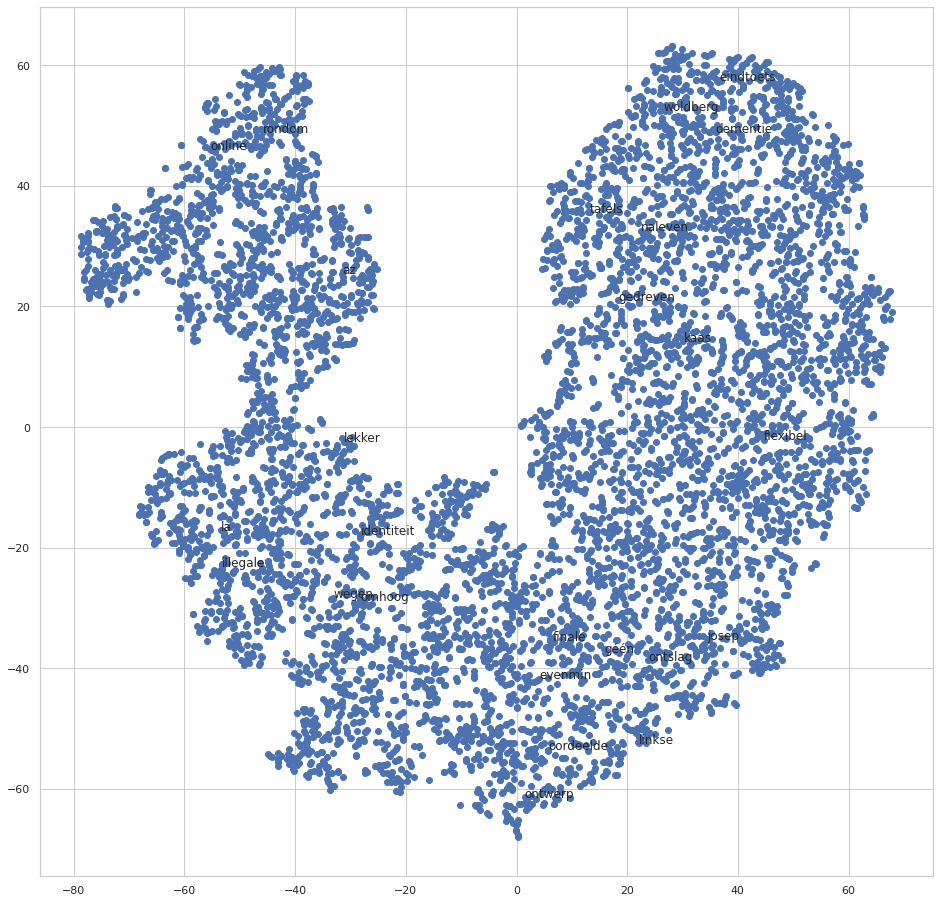

In [102]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import IPython


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(16, 16))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_function = plot_with_matplotlib

plot_function(x_vals, y_vals, labels)